In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import tensorflow as tf

from tensorflow.keras.applications.densenet import DenseNet169, DenseNet201, DenseNet121
from tensorflow.keras.layers import Input, Flatten, Dense, BatchNormalization, Activation, Dropout, GlobalAveragePooling2D, GlobalMaxPooling2D, Concatenate
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import losses, optimizers, activations, metrics
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from PIL import Image

import os
from time import time

print(os.listdir("../input"))

INPUT_SHAPE = (50, 50, 3)

DATA_PATH = os.path.join("../input/", "cell_images/cell_images")

# Any results you write to the current directory are saved as output.

['cell_images']


In [2]:
infected = os.listdir('../input/cell_images/cell_images/Parasitized/') 
uninfected = os.listdir('../input/cell_images/cell_images/Uninfected/')

import matplotlib.pyplot as plt
import seaborn as sns
import cv2

In [3]:
data = []
labels = []

for i in infected:
    try:
    
        image = cv2.imread("../input/cell_images/cell_images/Parasitized/"+i)
        image_array = Image.fromarray(image , 'RGB')
        resize_img = image_array.resize((50 , 50))
        rotated45 = resize_img.rotate(45)
        rotated75 = resize_img.rotate(75)
        blur = cv2.blur(np.array(resize_img) ,(10,10))
        data.append(np.array(resize_img))
        data.append(np.array(rotated45))
        data.append(np.array(rotated75))
        data.append(np.array(blur))
        labels.append(1)
        labels.append(1)
        labels.append(1)
        labels.append(1)
        
    except AttributeError:
        print('')
    
for u in uninfected:
    try:
        
        image = cv2.imread("../input/cell_images/cell_images/Uninfected/"+u)
        image_array = Image.fromarray(image , 'RGB')
        resize_img = image_array.resize((50 , 50))
        rotated45 = resize_img.rotate(45)
        rotated75 = resize_img.rotate(75)
        data.append(np.array(resize_img))
        data.append(np.array(rotated45))
        data.append(np.array(rotated75))
        labels.append(0)
        labels.append(0)
        labels.append(0)
        
    except AttributeError:
        print('')

In [4]:
cells = np.array(data)
labels = np.array(labels)

np.save('Cells' , cells)
np.save('Labels' , labels)

In [5]:
from sklearn.model_selection import train_test_split

train_x , x , train_y , y = train_test_split(cells , labels , test_size = 0.2 , random_state = 111)

eval_x , test_x , eval_y , test_y = train_test_split(x , y ,test_size = 0.5 , random_state = 111)

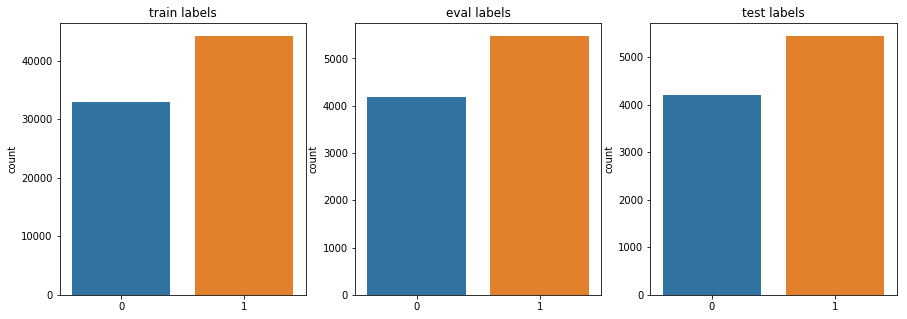

In [6]:
plt.figure(1 , figsize = (15 ,5))
n = 0 
for z , j in zip([train_y , eval_y , test_y] , ['train labels','eval labels','test labels']):
    n += 1
    plt.subplot(1 , 3  , n)
    sns.countplot(x = z )
    plt.title(j)
plt.show()

In [7]:
from tensorflow.keras.applications.densenet import DenseNet169, DenseNet201, DenseNet121
from tensorflow.keras.layers import Input, Flatten, Dense, BatchNormalization, Activation, Dropout, GlobalAveragePooling2D, GlobalMaxPooling2D, Concatenate
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import losses, optimizers, activations, metrics

In [8]:
class Densenet:
    def __init__(self, loss, optmizer, metrics):
        self.loss = loss
        self.optimizer = optmizer
        self.metrics = metrics
    
    def create_model(self, output_space: int) -> Model:
        base_model = DenseNet121(input_shape=INPUT_SHAPE, include_top=False)
        out0 = base_model.output
        out1 = GlobalMaxPooling2D()(out0)
        out2 = GlobalAveragePooling2D()(out0)
        out3 = Flatten()(out0)
        out = Concatenate(axis=-1)([out1, out2, out3])
        out = Dropout(0.5)(out)
        
        predictions = Dense(output_space, activation="sigmoid")(out)
        
        model = Model(inputs=base_model.input, outputs=predictions)

        model.compile(loss=self.loss, optimizer=self.optimizer, metrics=self.metrics)
        #model.summary()
        return model

In [9]:
from keras.callbacks import LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau

def step_decay(epoch):
    initial_lrate = 0.1
    drop = 0.5
    epochs_drop = 2
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

learning_rate = LearningRateScheduler(step_decay)

rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_delta=1e-7)

callbacks_list = [learning_rate, rlrp]

Using TensorFlow backend.


In [10]:
model = Densenet(
    losses.binary_crossentropy,
    optimizers.Adam(lr=10e-5),
    ["accuracy"]
).create_model(1)

Instructions for updating:
Colocations handled automatically by placer.
29089792/29084464 [==============================] - 1s 0us/step
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [11]:
model.fit(train_x, train_y,
          validation_data=(eval_x, eval_y),
          batch_size=512,
          epochs=30,
          verbose=1)

Train on 77162 samples, validate on 9645 samples
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/30
77162/77162 [==============================] - 67s 872us/sample - loss: 0.1826 - acc: 0.9302 - val_loss: 0.1174 - val_acc: 0.9603
Epoch 2/30
77162/77162 [==============================] - 40s 525us/sample - loss: 0.0795 - acc: 0.9723 - val_loss: 0.0882 - val_acc: 0.9711
Epoch 3/30
77162/77162 [==============================] - 40s 524us/sample - loss: 0.0526 - acc: 0.9815 - val_loss: 0.0832 - val_acc: 0.9707
Epoch 4/30
77162/77162 [==============================] - 40s 520us/sample - loss: 0.0340 - acc: 0.9880 - val_loss: 0.0948 - val_acc: 0.9710
Epoch 5/30
77162/77162 [==============================] - 41s 525us/sample - loss: 0.0217 - acc: 0.9920 - val_loss: 0.1050 - val_acc: 0.9703
Epoch 6/30
77162/77162 [==============================] - 40s 523us/sample - loss: 0.0174 - acc: 0.9939 - val_loss: 0.13

In [12]:
accuracy = model.evaluate(test_x, test_y, verbose=1)
print('\n', 'Test_Accuracy:-', accuracy[1])

9646/9646 [==============================] - 8s 786us/sample - loss: 0.1851 - acc: 0.9720

 Test_Accuracy:- 0.9720091


In [13]:
results = model.predict(test_x)

In [14]:
results = np.argmax(results,axis=1)
results = pd.Series(results,name="Label")

In [15]:
len(results)

9646

In [16]:
submission = pd.concat([pd.Series(range(1,9647),name = "ImageId"),results],axis = 1)

submission.to_csv("submission.csv",index=False)